In [1]:

import numpy as np;
import matplotlib.pyplot as plt;
import pickle;
import plotly.graph_objects as go
import plotly.io as pio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [2]:
# Load the axis values
prefix = "data/v5_"
n = "3"

with open(prefix + "etheta_" + n + ".pkl", "rb") as file:
    etheta_data = pickle.load(file)
E_values = np.array(etheta_data['E'])  # Energy axis values (array of length 200)
theta_values = np.array(etheta_data['theta'])  # Theta axis values (array of length 10)

print("Loaded axis data:")
print(f"E axis has {len(E_values)} points ranging from {E_values[0]} to {E_values[-1]} MeV.")
print(f"Theta axis has {len(theta_values)} points ranging from {theta_values[0]} to {theta_values[-1]} degrees.")

print(theta_values)

# Load the cross-sectional data (images)
with open(prefix + "xsdata_" + n +".pkl", "rb") as file:
    xsdata_list = pickle.load(file)  # List of arrays, each array is shape (200, 10)

num_samples = len(xsdata_list)
print(f"Loaded {len(xsdata_list)} images.")
print(f"Shape of the first image: {xsdata_list[0].shape}")


# Load the resonance information
with open(prefix + "info_" + n + ".pkl", "rb") as file:
    info_data = pickle.load(file)  # List of dictionaries, one per image

print(f"Loaded info for {len(info_data)} images.")
print(f"First image info keys: {info_data[0].keys()}")



Loaded axis data:
E axis has 200 points ranging from 0.1 to 6.0 MeV.
Theta axis has 30 points ranging from 0.6981317007977318 to 2.6179938779914944 degrees.
[0.6981317  0.76433384 0.83053599 0.89673813 0.96294028 1.02914242
 1.09534457 1.16154671 1.22774885 1.293951   1.36015314 1.42635529
 1.49255743 1.55875957 1.62496172 1.69116386 1.75736601 1.82356815
 1.88977029 1.95597244 2.02217458 2.08837673 2.15457887 2.22078101
 2.28698316 2.3531853  2.41938745 2.48558959 2.55179173 2.61799388]
Loaded 3 images.
Shape of the first image: (200, 30)
Loaded info for 3 images.
First image info keys: dict_keys(['n_res', 'res'])


[[ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 ...
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]]


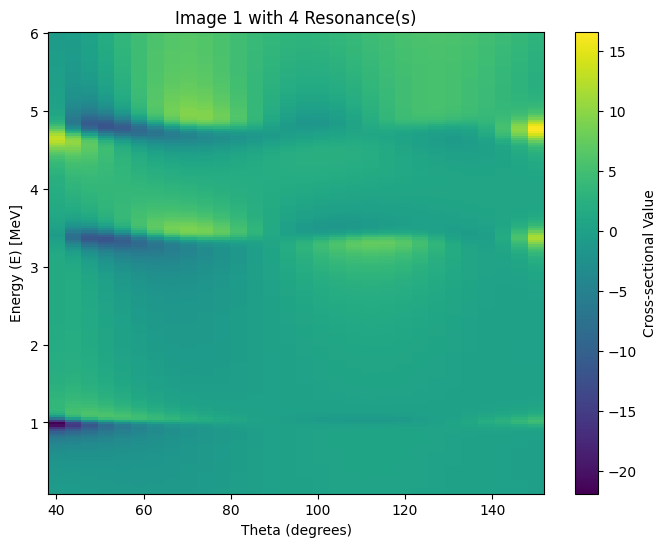

Image 1 Resonance Parameters:
  E_res: 4.7844 MeV, Gamma_res: 0.3096, l_res: 3
  E_res: 4.6555 MeV, Gamma_res: 0.3250, l_res: 0
  E_res: 1.0056 MeV, Gamma_res: 0.1374, l_res: 1
  E_res: 3.3788 MeV, Gamma_res: 0.2488, l_res: 3
[[ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 ...
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]]


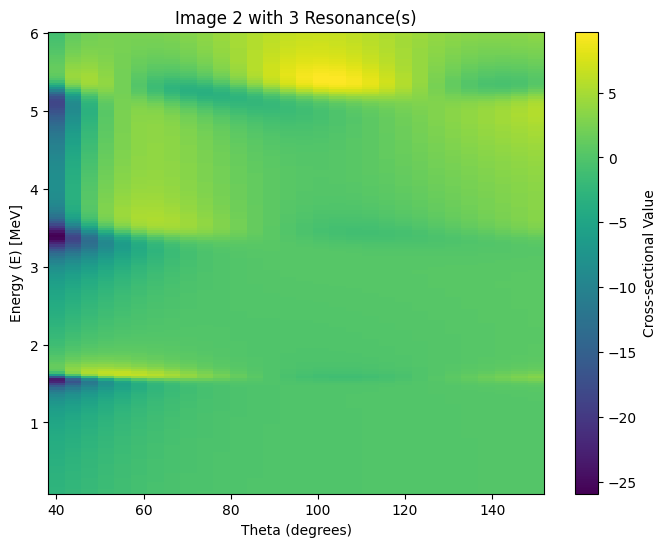

Image 2 Resonance Parameters:
  E_res: 5.2411 MeV, Gamma_res: 0.4049, l_res: 2
  E_res: 1.5743 MeV, Gamma_res: 0.1317, l_res: 1
  E_res: 3.3962 MeV, Gamma_res: 0.3761, l_res: 1
[[ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 ...
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]
 [ 40.          43.79310345  47.5862069  ... 142.4137931  146.20689655
  150.        ]]


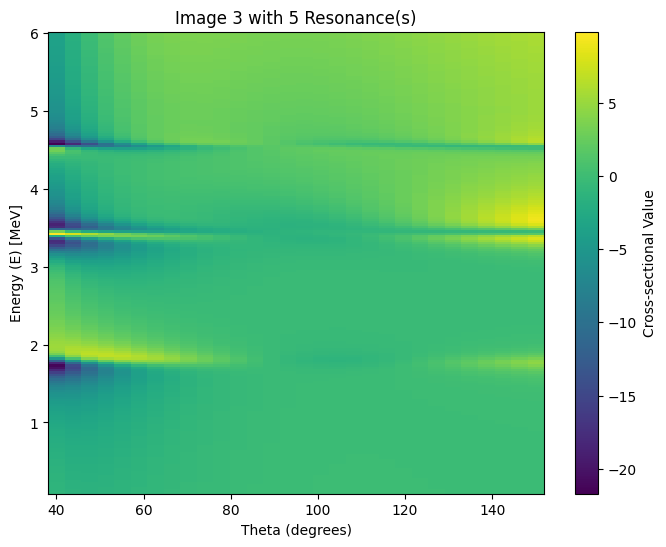

Image 3 Resonance Parameters:
  E_res: 1.7746 MeV, Gamma_res: 0.1938, l_res: 1
  E_res: 3.4115 MeV, Gamma_res: 0.3204, l_res: 1
  E_res: 4.5581 MeV, Gamma_res: 0.0721, l_res: 1
  E_res: 3.4304 MeV, Gamma_res: 0.1191, l_res: 1
  E_res: 3.5405 MeV, Gamma_res: 0.7409, l_res: 0


In [3]:
def plot_image(index):
    image_data = xsdata_list[index]  # Shape: (200, 10)
    
    # Convert theta_values from radians to degrees
    theta_values_deg = theta_values * (180.0 / np.pi)
    
    # Create a meshgrid with theta in degrees
    theta_grid_deg, E_grid = np.meshgrid(theta_values_deg, E_values)

    print(theta_grid_deg)
    
    plt.figure(figsize=(8, 6))
    # Plot using pcolormesh with theta in degrees on x-axis and energy on y-axis
    plt.pcolormesh(theta_grid_deg, E_grid, image_data, shading='auto', cmap='viridis')
    plt.colorbar(label='Cross-sectional Value')
    plt.xlabel('Theta (degrees)')
    plt.ylabel('Energy (E) [MeV]')
    plt.title(f'Image {index+1} with {info_data[index]["n_res"]} Resonance(s)')
    plt.show()
    
    # Print resonance parameters
    print(f"Image {index+1} Resonance Parameters:")
    for res in info_data[index]['res']:
        print(f"  E_res: {res['E_res']:.4f} MeV, Gamma_res: {res['Gamma_res']:.4f}, l_res: {res['l_res']}")



# Create a meshgrid from theta_values and E_values
theta_grid, E_grid = np.meshgrid(theta_values, E_values)


# Plot the first three images
for idx in range(3):
    plot_image(idx)


In [21]:
# Convert xsdata_list to a tensor
images = np.array(xsdata_list)  # Shape: (num_samples, 200, 10)
images = images[:, np.newaxis, :, :]  # Add channel dimension: (num_samples, 1, 200, 10)
images = torch.tensor(images, dtype=torch.float32)

print(f"Images tensor shape: {images.shape}")  # Should be (num_samples, 1, 200, 10)


Images tensor shape: torch.Size([11110, 1, 200, 30])


In [20]:
# Parameters
max_objects = 10  # Maximum number of resonances per image

# Initialize target tensors
num_objects = torch.zeros(num_samples, dtype=torch.long)
energies = torch.zeros(num_samples, max_objects, dtype=torch.float32)
gammas = torch.zeros(num_samples, max_objects, dtype=torch.float32)
ls = torch.zeros(num_samples, max_objects, dtype=torch.long)
masks = torch.zeros(num_samples, max_objects, dtype=torch.float32)

for i in range(num_samples):
    n_res = info_data[i]['n_res']
    num_objects[i] = n_res
    masks[i, :n_res] = 1
    for j, res in enumerate(info_data[i]['res']):
        if j >= max_objects:
            break  # Ignore extra resonances beyond max_objects
        energies[i, j] = res['E_res']
        gammas[i, j] = res['Gamma_res']
        ls[i, j] = res['l_res']

targets = {
    'num_objects': num_objects,
    'energies': energies,
    'gammas': gammas,
    'ls': ls,
    'masks': masks,
}


In [6]:
# Compute the gradient of an image with Sobel operator.
def compute_image_gradient(image):
    """
    Computes the gradient of an image using the Sobel operator.

    Args:
        image (torch.Tensor): Input image tensor of shape (C, H, W).

    Returns:
        torch.Tensor: Gradient image tensor of shape (C, H, W).
    """
    # Define Sobel kernels
    sobel_kernel_x = torch.tensor([[1, 0, -1],
                                   [2, 0, -2],
                                   [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sobel_kernel_y = torch.tensor([[1, 2, 1],
                                   [0, 0, 0],
                                   [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Move kernels to the same device as the image
    device = image.device
    sobel_kernel_x = sobel_kernel_x.to(device)
    sobel_kernel_y = sobel_kernel_y.to(device)

    # Pad the image to keep the same spatial dimensions
    image = image.unsqueeze(0)  # Add batch dimension
    padding = 1  # For 3x3 kernel
    image_padded = F.pad(image, (padding, padding, padding, padding), mode='reflect')

    # Convolve with Sobel kernels
    grad_x = F.conv2d(image_padded, sobel_kernel_x)
    grad_y = F.conv2d(image_padded, sobel_kernel_y)

    # Compute the gradient magnitude
    grad_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2).squeeze(0)  # Remove batch dimension

    return grad_magnitude


In [7]:
class ResonanceDataset(Dataset):
    def __init__(self, data, targets, compute_gradients=False):
        self.data = data  # Shape: (num_samples, 1, H, W)
        self.targets = targets  # Dictionary with target parameters
        self.compute_gradients = compute_gradients

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]  # Shape: (1, H, W)
        target = {key: val[idx] for key, val in self.targets.items()}

        if self.compute_gradients:
            # Compute gradient for each channel
            channels = []
            for c in range(image.shape[0]):
                grad = compute_image_gradient(image[c])
                channels.append(grad)
            image = torch.stack(channels, dim=0)  # Shape: (C, H, W)

        return image, target


In [8]:
# Split the dataset
from torch.utils.data import random_split

dataset = ResonanceDataset(images, targets, compute_gradients=True)
train_size = int(0.8 * len(dataset)) # 80-20 Training to validation split
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])




Sample Index: 0
Number of Objects: 3
Energies: [4.3019004 1.9239975 3.88681  ]
Gammas: [0.294049   0.06518395 0.17889959]
Angular Momenta (ls): [2 4 0]


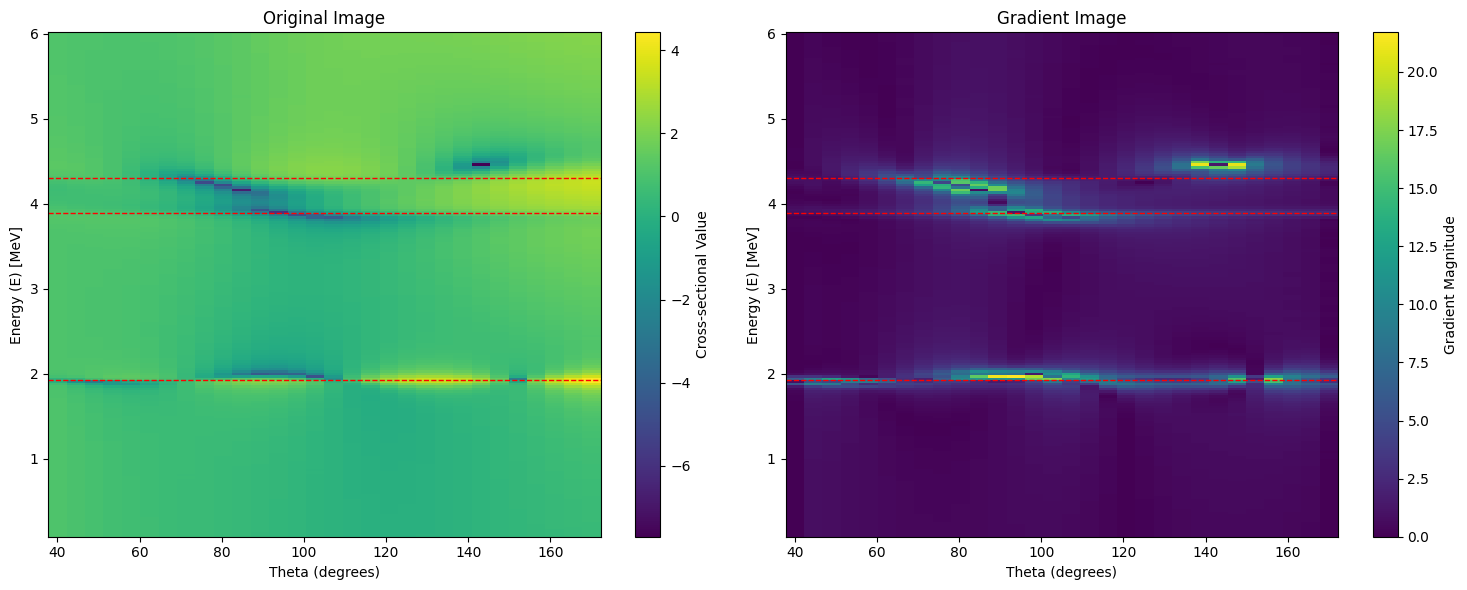

Sample Index: 1
Number of Objects: 5
Energies: [2.4805624 1.5097286 4.5291514 5.259642  1.3346839]
Gammas: [0.5965059  0.23901351 0.11203849 0.20943373 0.15858768]
Angular Momenta (ls): [0 0 3 4 2]


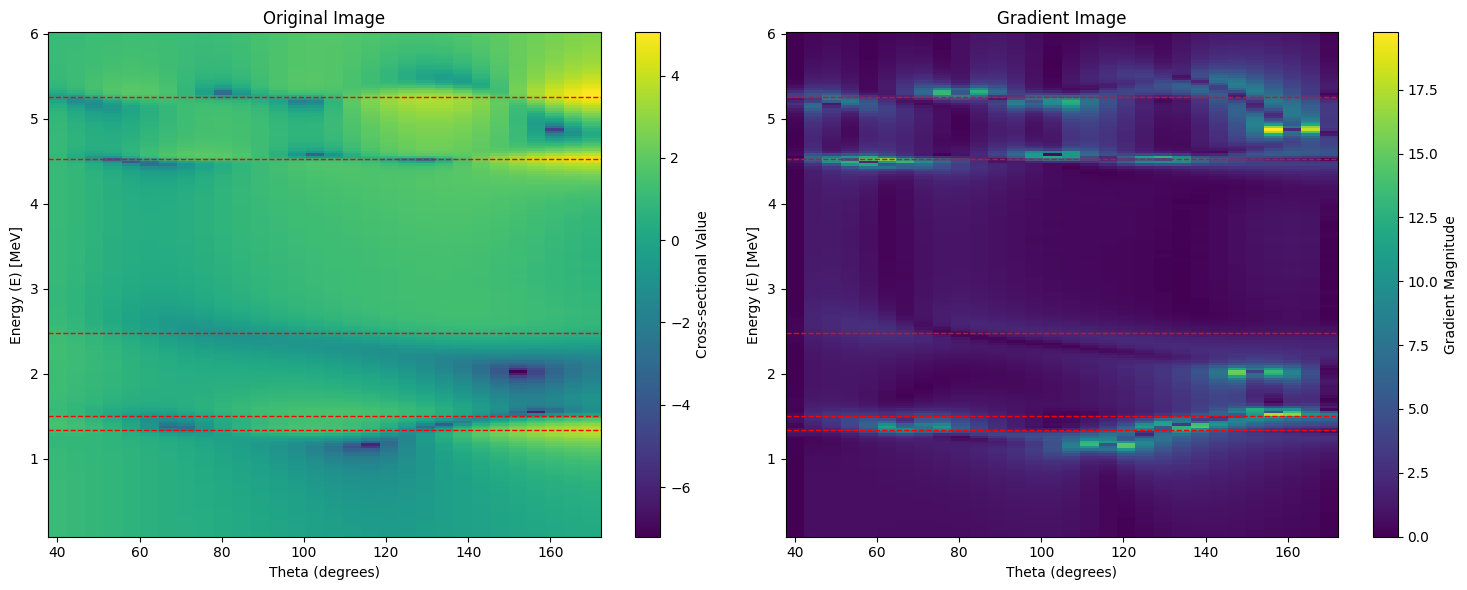

Sample Index: 2
Number of Objects: 4
Energies: [4.2345333 0.8326832 5.0540066 2.0788147]
Gammas: [0.3949057  0.06295622 0.0549898  0.27004305]
Angular Momenta (ls): [1 3 4 1]


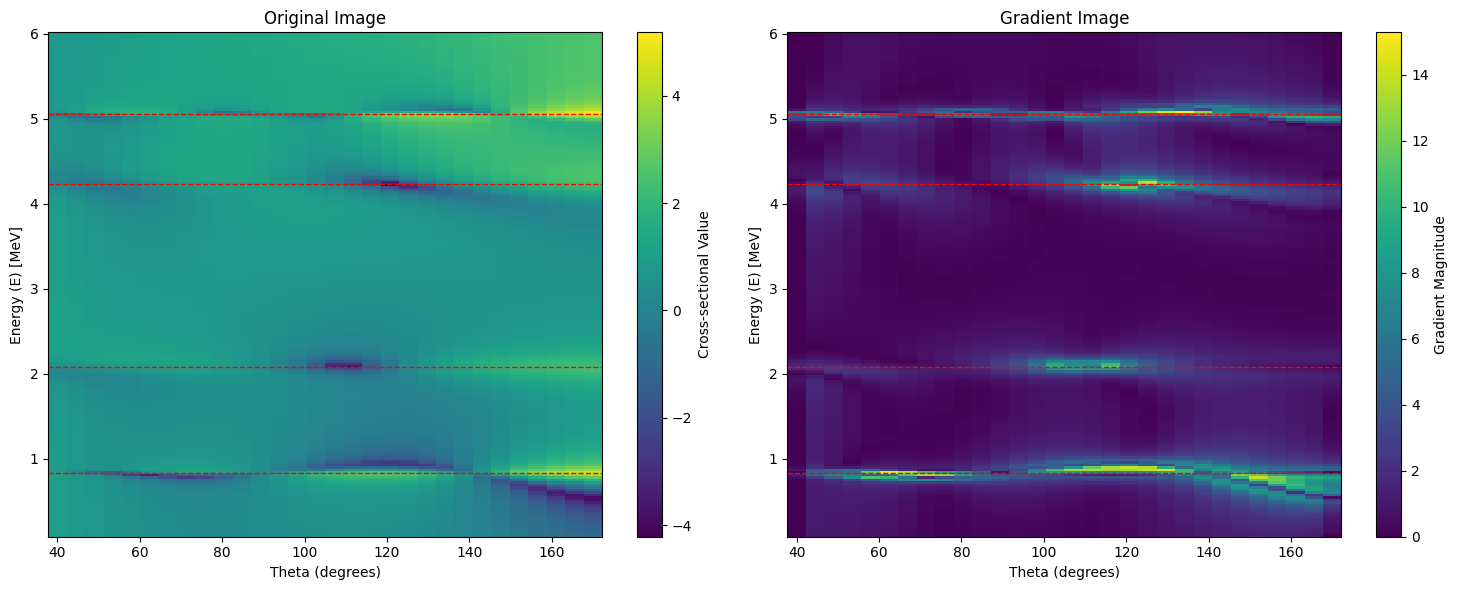

In [9]:
# Plot the original image against the sobel filter gradient version
def plot_image_gradient_comparision(index):
    # Convert theta axis to degrees
    theta_values_deg = theta_values * (180.0 / np.pi)
    theta_grid_deg, E_grid = np.meshgrid(theta_values_deg, E_values)

    # Get the gradient image and target from the dataset
    gradient_image, target = dataset[index]  # Returns (image, target)

    # Get the original image from the images array
    original_image = images[index]

    # Convert tensors to numpy arrays and squeeze to remove singleton dimensions
    if isinstance(original_image, torch.Tensor):
        original_image_np = original_image.squeeze().numpy()
    else:
        original_image_np = original_image.squeeze()

    if isinstance(gradient_image, torch.Tensor):
        gradient_image_np = gradient_image.squeeze().numpy()
    else:
        gradient_image_np = gradient_image.squeeze()

    # Retrieve target parameters
    num_objects = target['num_objects'].item()
    energies = target['energies'][:num_objects].numpy()
    gammas = target['gammas'][:num_objects].numpy()
    ls = target['ls'][:num_objects].numpy()

    # Print out the target parameters
    print(f"Sample Index: {index}")
    print(f"Number of Objects: {num_objects}")
    print(f"Energies: {energies}")
    print(f"Gammas: {gammas}")
    print(f"Angular Momenta (ls): {ls}")

    # Plot the images with correct axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Original Image
    ax1 = axes[0]
    im1 = ax1.pcolormesh(theta_grid_deg, E_grid, original_image_np, shading='auto', cmap='viridis')
    ax1.set_title('Original Image')
    ax1.set_xlabel('Theta (degrees)')
    ax1.set_ylabel('Energy (E) [MeV]')
    fig.colorbar(im1, ax=ax1, label='Cross-sectional Value')

    # Overlay the resonance energies on the original image
    for energy in energies:
        ax1.axhline(y=energy, color='red', linestyle='--', linewidth=1)

    # Gradient Image
    ax2 = axes[1]
    im2 = ax2.pcolormesh(theta_grid_deg, E_grid, gradient_image_np, shading='auto', cmap='viridis')
    ax2.set_title('Gradient Image')
    ax2.set_xlabel('Theta (degrees)')
    ax2.set_ylabel('Energy (E) [MeV]')
    fig.colorbar(im2, ax=ax2, label='Gradient Magnitude')

    # Overlay the resonance energies on the gradient image
    for energy in energies:
        ax2.axhline(y=energy, color='red', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.show()

for i in range(3):
    plot_image_gradient_comparision(i)


In [22]:
class ResonanceDetectionModel(nn.Module):
    def __init__(self, max_objects=10, num_l_classes=5):
        super(ResonanceDetectionModel, self).__init__()
        self.max_objects = max_objects
        self.num_l_classes = num_l_classes

        # Convolutional layers with batch normalization and pooling
        self.conv1 = nn.Conv2d(1, 80, kernel_size=2, padding='same')
        self.bn1 = nn.BatchNorm2d(80)
        self.conv2 = nn.Conv2d(80, 160, kernel_size=2, padding='same')
        self.bn2 = nn.BatchNorm2d(160)
        self.conv3 = nn.Conv2d(160, 320, kernel_size=2, padding='same')
        self.bn3 = nn.BatchNorm2d(320)
        self.conv4 = nn.Conv2d(320, 640, kernel_size=2, padding='same')
        self.bn4 = nn.BatchNorm2d(640)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2,1))
        
        # Calculate the flattened size after convolutions
        self.flattened_size = self.calculate_flattened_size()
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        
        # Output layers
        self.num_objects = nn.Linear(128, 1)  # Scalar output for number of objects
        # For each object: confidence, E_res, Gamma_res, and l (as classification)
        self.object_params = nn.Linear(128, max_objects * (1 + 2 + num_l_classes))  # Outputs per-object parameters

    def calculate_flattened_size(self):
        # Create a dummy input to pass through the conv layers and get the output size
        # Adjust the dimensions as per your input data (e.g., (1, 1, 200, 10))
        dummy_input = torch.zeros(1, 1, 200, 30)
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        flattened_size = x.view(1, -1).size(1)
        return flattened_size

    def forward(self, x):
        batch_size = x.size(0)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        # Predict the number of objects (regressed to a float between 0 and max_objects)
        num_objects = torch.sigmoid(self.num_objects(x)) * self.max_objects
        
        # Predict per-object parameters
        object_params = self.object_params(x).view(batch_size, self.max_objects, -1)
        
        # Split the object_params into individual components
        confidences = torch.sigmoid(object_params[:, :, 0])  # Confidence scores between 0 and 1
        energies = object_params[:, :, 1]  # Energy values
        gammas = torch.exp(object_params[:, :, 2])  # Gamma values (use F.softplus for positive values)
        l_logits = object_params[:, :, 3:]  # Logits for l classes
        
        outputs = {
            'num_objects': num_objects.squeeze(1),  # Shape: (batch_size,)
            'confidences': confidences,             # Shape: (batch_size, max_objects)
            'energies': energies,                   # Shape: (batch_size, max_objects)
            'gammas': gammas,                       # Shape: (batch_size, max_objects)
            'l_logits': l_logits                    # Shape: (batch_size, max_objects, num_l_classes)
        }
        return outputs


In [11]:
def loss_function(outputs, targets):
    # Loss on the number of objects detected
    loss_num_objects = F.mse_loss(outputs['num_objects'], targets['num_objects'].float())

    # Masks to indicate valid objects
    masks = targets['masks']  # Shape: (batch_size, max_objects)

    # Loss on confidences (Binary Cross-Entropy)
    loss_confidences = F.binary_cross_entropy(outputs['confidences'], masks.float())

    # Loss on energies and gammas (only for valid objects)
    energies_loss = F.mse_loss(outputs['energies'] * masks, targets['energies'] * masks)
    gammas_loss = F.mse_loss(outputs['gammas'] * masks, targets['gammas'] * masks)

    # Loss on l (angular momentum classes)
    l_logits = outputs['l_logits']  # Shape: (batch_size, max_objects, num_l_classes)
    l_targets = targets['ls'].long()  # Shape: (batch_size, max_objects)
    # Flatten tensors and apply mask
    l_logits = l_logits.view(-1, outputs['l_logits'].size(-1))  # (batch_size * max_objects, num_l_classes)
    l_targets = l_targets.view(-1)  # (batch_size * max_objects)
    masks_flat = masks.view(-1)
    # Select valid entries
    l_logits = l_logits[masks_flat == 1]
    l_targets = l_targets[masks_flat == 1]
    loss_l = F.cross_entropy(l_logits, l_targets)

    # Total loss
    total_loss = loss_num_objects + loss_confidences + energies_loss + gammas_loss + loss_l

    # Return all loss components
    loss_dict = {
        'total_loss': total_loss,
        'loss_num_objects': loss_num_objects,
        'loss_confidences': loss_confidences,
        'energies_loss': energies_loss,
        'gammas_loss': gammas_loss,
        'ls_loss': loss_l
    }

    return loss_dict


In [12]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Initialize the model, optimizer, and loss function
model = ResonanceDetectionModel(max_objects=max_objects)
model.to(device)  # Move the model to the device
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


/Users/sam/.pyenv/versions/3.12.3/envs/nuclear-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,


In [23]:
# Training and validation loop
num_epochs = 100  # Number of epochs
best_val_loss = float('inf')  # Initialize best validation loss for checkpointing

# Initialize lists to store training and validation losses and metrics before the training loop
train_losses = []
val_losses = []
train_r2_scores_history = {'num_objects': [], 'energies': [], 'gammas': []}
val_r2_scores_history = {'num_objects': [], 'energies': [], 'gammas': []}
train_l_accuracy_history = []
val_l_accuracy_history = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_dict = {
        'total_loss': 0.0,
        'loss_num_objects': 0.0,
        'loss_confidences': 0.0,
        'energies_loss': 0.0,
        'gammas_loss': 0.0,
        'ls_loss': 0.0
    }
    # Initialize lists to store predictions and targets for R² computation
    train_outputs_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    train_targets_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    
    for batch_images, batch_targets in train_loader:
        # Move data and targets to the device
        batch_images = batch_images.to(device)
        batch_targets = {key: val.to(device) for key, val in batch_targets.items()}
        
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss_dict = loss_function(outputs, batch_targets)
        loss = loss_dict['total_loss']
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        for key in train_loss_dict:
            train_loss_dict[key] += loss_dict[key].item()
        
        # Accumulate predictions and targets for R² computation
        train_outputs_accum['num_objects'].append(outputs['num_objects'].detach().cpu())
        train_targets_accum['num_objects'].append(batch_targets['num_objects'].detach().cpu())
        
        # For per-object parameters, we need to consider only valid objects
        masks = batch_targets['masks'].detach().cpu()
        valid_indices = masks.view(-1).bool() # Remove zero entries (from padding)
        
        for param in ['energies', 'gammas']:
            # Apply masks to outputs and targets
            outputs_param = (outputs[param].detach().cpu() * masks).view(-1)
            targets_param = (batch_targets[param].detach().cpu() * masks).view(-1)
            train_outputs_accum[param].append(outputs_param[valid_indices])
            train_targets_accum[param].append(targets_param[valid_indices])

        # For l (classification)
        l_logits = outputs['l_logits'].detach().cpu()
        l_preds = torch.argmax(l_logits, dim=-1)
        l_preds = l_preds.view(-1)[valid_indices]
        l_targets = batch_targets['ls'].detach().cpu().view(-1)[valid_indices]
        train_outputs_accum['ls'].append(l_preds)
        train_targets_accum['ls'].append(l_targets)
            
    # Compute average losses
    for key in train_loss_dict:
        train_loss_dict[key] /= len(train_loader)
    
    # For regression outputs
    train_r2_scores = {}
    for key in ['num_objects', 'energies', 'gammas']:
        train_outputs_concat = torch.cat(train_outputs_accum[key], dim=0).numpy()
        train_targets_concat = torch.cat(train_targets_accum[key], dim=0).numpy()
        train_r2_scores[key] = r2_score(train_targets_concat, train_outputs_concat)

    # For l (classification)
    train_l_preds = torch.cat(train_outputs_accum['ls'], dim=0).numpy()
    train_l_targets = torch.cat(train_targets_accum['ls'], dim=0).numpy()
    train_l_accuracy = accuracy_score(train_l_targets, train_l_preds)

    # Append losses and metrics to the lists for plotting later
    train_losses.append(train_loss_dict['total_loss'])
    for key in ['num_objects', 'energies', 'gammas']:
        train_r2_scores_history[key].append(train_r2_scores[key])
    train_l_accuracy_history.append(train_l_accuracy)

        
    # Validation phase
    model.eval()
    val_loss_dict = {
        'total_loss': 0.0,
        'loss_num_objects': 0.0,
        'loss_confidences': 0.0,
        'energies_loss': 0.0,
        'gammas_loss': 0.0,
        'ls_loss': 0.0
    }
    val_outputs_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    val_targets_accum = {
        'num_objects': [],
        'energies': [],
        'gammas': [],
        'ls': []
    }
    with torch.no_grad():
        for batch_images, batch_targets in val_loader:
            # Move data and targets to the device
            batch_images = batch_images.to(device)
            batch_targets = {key: val.to(device) for key, val in batch_targets.items()}
            
            outputs = model(batch_images)
            loss_dict = loss_function(outputs, batch_targets)
            
            # Accumulate losses
            for key in val_loss_dict:
                val_loss_dict[key] += loss_dict[key].item()
            
            # Accumulate predictions and targets for R² computation
            val_outputs_accum['num_objects'].append(outputs['num_objects'].detach().cpu())
            val_targets_accum['num_objects'].append(batch_targets['num_objects'].detach().cpu())
            
            masks = batch_targets['masks'].detach().cpu()
            valid_indices = masks.view(-1).bool()
            for param in ['energies', 'gammas']:
                outputs_param = (outputs[param].detach().cpu() * masks).view(-1)
                targets_param = (batch_targets[param].detach().cpu() * masks).view(-1)
                val_outputs_accum[param].append(outputs_param[valid_indices])
                val_targets_accum[param].append(targets_param[valid_indices])
                
            # For l (classification)
            l_logits = outputs['l_logits'].detach().cpu()
            l_preds = torch.argmax(l_logits, dim=-1)
            l_preds = l_preds.view(-1)[valid_indices]
            l_targets = batch_targets['ls'].detach().cpu().view(-1)[valid_indices]
            val_outputs_accum['ls'].append(l_preds)
            val_targets_accum['ls'].append(l_targets)

    
    # Compute average losses
    for key in val_loss_dict:
        val_loss_dict[key] /= len(val_loader)
    
    # Concatenate all accumulated outputs and targets
    # For regression outputs
    val_r2_scores = {}
    for key in ['num_objects', 'energies', 'gammas']:
        val_outputs_concat = torch.cat(val_outputs_accum[key], dim=0).numpy()
        val_targets_concat = torch.cat(val_targets_accum[key], dim=0).numpy()
        val_r2_scores[key] = r2_score(val_targets_concat, val_outputs_concat)

    # For l (classification)
    val_l_preds = torch.cat(val_outputs_accum['ls'], dim=0).numpy()
    val_l_targets = torch.cat(val_targets_accum['ls'], dim=0).numpy()
    val_l_accuracy = accuracy_score(val_l_targets, val_l_preds)

    # Append losses and metrics to the lists for plotting later
    val_losses.append(val_loss_dict['total_loss'])
    for key in ['num_objects', 'energies', 'gammas']:
        val_r2_scores_history[key].append(val_r2_scores[key])
    val_l_accuracy_history.append(val_l_accuracy)
    
    # Save the model checkpoint if validation loss improved
    if val_loss_dict['total_loss'] < best_val_loss:
        best_val_loss = val_loss_dict['total_loss']
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Print Training Metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Training Losses:")
    print(f"    Total Loss: {train_loss_dict['total_loss']:.4f}")
    print(f"    Num Objects Loss: {train_loss_dict['loss_num_objects']:.4f}")
    print(f"    Confidences Loss: {train_loss_dict['loss_confidences']:.4f}")
    print(f"    Energies Loss: {train_loss_dict['energies_loss']:.4f}")
    print(f"    Gammas Loss: {train_loss_dict['gammas_loss']:.4f}")
    print(f"    ls Loss: {train_loss_dict['ls_loss']:.4f}")
    print(f"  Training Metrics:")
    print(f"    Num Objects R²: {train_r2_scores['num_objects']:.4f}")
    print(f"    Energies R²: {train_r2_scores['energies']:.4f}")
    print(f"    Gammas R²: {train_r2_scores['gammas']:.4f}")
    print(f"    ls Accuracy: {train_l_accuracy:.4f}")

    # Print Validation Metrics
    print(f"  Validation Losses:")
    print(f"    Total Loss: {val_loss_dict['total_loss']:.4f}")
    print(f"    Num Objects Loss: {val_loss_dict['loss_num_objects']:.4f}")
    print(f"    Confidences Loss: {val_loss_dict['loss_confidences']:.4f}")
    print(f"    Energies Loss: {val_loss_dict['energies_loss']:.4f}")
    print(f"    Gammas Loss: {val_loss_dict['gammas_loss']:.4f}")
    print(f"    ls Loss: {val_loss_dict['ls_loss']:.4f}")
    print(f"  Validation Metrics:")
    print(f"    Num Objects R²: {val_r2_scores['num_objects']:.4f}")
    print(f"    Energies R²: {val_r2_scores['energies']:.4f}")
    print(f"    Gammas R²: {val_r2_scores['gammas']:.4f}")
    print(f"    ls Accuracy: {val_l_accuracy:.4f}")



RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x230400 and 76800x256)

In [ ]:
# Plotting Training and Validation Losses
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting R² Scores for Regression Parameters
for key in ['num_objects', 'energies', 'gammas']:
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), train_r2_scores_history[key], label=f'Training R² {key}')
    plt.plot(range(1, num_epochs+1), val_r2_scores_history[key], label=f'Validation R² {key}')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.ylim(0,1)
    plt.title(f'Training and Validation R² Score for {key.capitalize()} Over Epochs')
    plt.legend()
    plt.show()

# Plotting Classification Accuracy for l
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_l_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_l_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Training and Validation Accuracy for l Over Epochs')
plt.legend()
plt.show()


In [ ]:
# plt.hist(train_targets['gammas'].numpy().flatten(), bins=50, alpha=0.5, label='Train')
# plt.hist(val_targets['gammas'].numpy().flatten(), bins=50, alpha=0.5, label='Validation')
# plt.xlabel('Gamma Values')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()
